This project involves an end-to-end analysis of a restaurant review dataset, integrating transformer-based sentiment analysis, interactive visualizations, and unsupervised clustering. The dataset was first explored to understand its structure, revealing a mix of numerical, categorical, and textual columns. For extracting emotional tone from customer reviews, we used a pretrained Transformer model (distilbert-base-uncased-finetuned-sst-2-english) via Hugging Face’s pipeline("sentiment-analysis"), which added two new columns: SentimentLabel and SentimentScore. This allowed for fine-grained sentiment understanding of each review. Interactive visualizations were created using Plotly, showcasing sentiment distributions, average ratings across sentiment categories, and cuisine-wise breakdowns, offering deep insights into customer perception and business trends. For clustering, we focused on numerical columns (Rating, ReviewLength, SentimentScore, etc.), as K-Means relies on distance-based calculations that are only meaningful in numerical spaces. We addressed missing values (notably 39 in Rating) using mean imputation, and standardized the data with StandardScaler to ensure all features contributed equally. The Elbow Method helped determine the optimal number of clusters by plotting inertia for k = 1 to 10. Post this, we applied K-Means clustering, and evaluated the results using multiple metrics—Silhouette Score (higher is better), Calinski-Harabasz Index (higher indicates better separation), and Davies-Bouldin Score (lower is better). The resulting clusters were labeled and analyzed to uncover patterns in sentiment, review characteristics, and customer preferences. This comprehensive workflow demonstrates the power of combining NLP (via Transformers) with unsupervised machine learning to gain actionable insights from complex, real-world datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import plotly.express as px


In [2]:
df1=pd.read_csv('Zomato Restaurant names and Metadata.csv')
df2=pd.read_csv('Zomato Restaurant reviews.csv')

In [3]:
common_columns = set(df1.columns).intersection(set(df2.columns))
print("Common columns are:", common_columns)

Common columns are: set()


In [4]:
df = pd.merge(df1, df2, left_on='Name', right_on='Restaurant', how='inner')

In [5]:
df

,Name,Links,Cost,Collections,Cuisines,Timings,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Chinese Pavilion,https://www.zomato.com/hyderabad/chinese-pavil...,"1,000",NaN,"Chinese, Seafood","12 Noon to 3:30 PM, 7 PM to 11 PM",Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3,"53 Reviews , 54 Followers",6/5/2016 0:08,0
9996,Chinese Pavilion,https://www.zomato.com/hyderabad/chinese-pavil...,"1,000",NaN,"Chinese, Seafood","12 Noon to 3:30 PM, 7 PM to 11 PM",Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0
9997,Chinese Pavilion,https://www.zomato.com/hyderabad/chinese-pavil...,"1,000",NaN,"Chinese, Seafood","12 Noon to 3:30 PM, 7 PM to 11 PM",Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3
9998,Chinese Pavilion,https://www.zomato.com/hyderabad/chinese-pavil...,"1,000",NaN,"Chinese, Seafood","12 Noon to 3:30 PM, 7 PM to 11 PM",Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4,"13 Reviews , 144 Followers",5/31/2016 17:22,0


In [6]:
df.head()

,Name,Links,Cost,Collections,Cuisines,Timings,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [7]:
df.drop('Restaurant', axis=1, inplace=True)

In [8]:
df

,Name,Links,Cost,Collections,Cuisines,Timings,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Chinese Pavilion,https://www.zomato.com/hyderabad/chinese-pavil...,"1,000",NaN,"Chinese, Seafood","12 Noon to 3:30 PM, 7 PM to 11 PM",Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3,"53 Reviews , 54 Followers",6/5/2016 0:08,0
9996,Chinese Pavilion,https://www.zomato.com/hyderabad/chinese-pavil...,"1,000",NaN,"Chinese, Seafood","12 Noon to 3:30 PM, 7 PM to 11 PM",Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0
9997,Chinese Pavilion,https://www.zomato.com/hyderabad/chinese-pavil...,"1,000",NaN,"Chinese, Seafood","12 Noon to 3:30 PM, 7 PM to 11 PM",Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3
9998,Chinese Pavilion,https://www.zomato.com/hyderabad/chinese-pavil...,"1,000",NaN,"Chinese, Seafood","12 Noon to 3:30 PM, 7 PM to 11 PM",Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4,"13 Reviews , 144 Followers",5/31/2016 17:22,0


In [9]:
df.isnull().sum()

Name              0
Links             0
Cost              0
Collections    5000
Cuisines          0
Timings         100
Reviewer         38
Review           45
Rating           38
Metadata         38
Time             38
Pictures          0
dtype: int64

In [10]:
df.dtypes

Name           object
Links          object
Cost           object
Collections    object
Cuisines       object
Timings        object
Reviewer       object
Review         object
Rating         object
Metadata       object
Time           object
Pictures        int64
dtype: object

In [11]:
df.shape

(10000, 12)

In [12]:
df['Collections'] = df['Collections'].fillna('Not listed')


In [13]:
df['Timings'] = df['Timings'].fillna('00:00 AM to 00:00 PM')   

In [14]:
df['Reviewer'] = df['Reviewer'].fillna('Anonymous')
df['Review'] = df['Review'].fillna('No review')
df['Rating'] = df['Rating'].fillna('No rating') 
df['Metadata'] = df['Metadata'].fillna('Not available')
df['Time'] = df['Time'].fillna('Unknown')


In [15]:
df.isnull().sum()

Name           0
Links          0
Cost           0
Collections    0
Cuisines       0
Timings        0
Reviewer       0
Review         0
Rating         0
Metadata       0
Time           0
Pictures       0
dtype: int64

Top 10 Most Popular Cuisines

In [16]:
top_cuisines = df['Cuisines'].value_counts().nlargest(10).reset_index()
top_cuisines.columns = ['Cuisine', 'Count']

fig = px.bar(top_cuisines, x='Count', y='Cuisine', orientation='h',
             title='Top 10 Most Popular Cuisines',
             color='Count', color_continuous_scale='Viridis')
fig.show()

Restaurant Ratings Distribution

In [17]:
fig = px.histogram(df, x='Rating', nbins=20,
                   title='Distribution of Restaurant Ratings',
                   color_discrete_sequence=['#00cc96'])
fig.show()


Cost Distribution of Restaurants

In [18]:
df['Cost'] = df['Cost'].replace('[^0-9]', '', regex=True).astype(float)  # Clean cost column

fig = px.box(df, y='Cost',
             title='Cost Distribution Across Restaurants',
             points='all', color_discrete_sequence=['#636efa'])
fig.show()


Restaurant Activity Over Weekdays (If Timings Has Weekdays)

In [19]:
import re

df['Weekday'] = df['Timings'].apply(lambda x: re.findall(r'(Mon|Tue|Wed|Thu|Fri|Sat|Sun)', str(x))).str[0]

fig = px.histogram(df, x='Weekday',
                   title='Restaurant Activity Over Weekdays',
                   color_discrete_sequence=['#ab63fa'])
fig.show()


Pictures Uploaded vs Rating

In [20]:
fig = px.scatter(df, x='Pictures', y='Rating',
                 title='Number of Pictures vs Rating',
                 size='Pictures', color='Rating',
                 color_continuous_scale='Tealrose')
fig.show()


In [21]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')  


Average Rating per Cuisine

In [22]:
avg_rating = df.groupby('Cuisines')['Rating'].mean().nlargest(10).reset_index()

fig = px.bar(avg_rating, x='Cuisines', y='Rating',
             title='Top 10 Cuisines by Average Rating',
             color='Rating', color_continuous_scale='Bluered_r')
fig.show()


 Number of Reviews vs Rating Scatter Plot

In [23]:
df['ReviewLength'] = df['Review'].astype(str).apply(len)

fig = px.scatter(df, x='ReviewLength', y='Rating',
                 title='Review Length vs Rating',
                 trendline='ols',
                 color='Rating', color_continuous_scale='Inferno')
fig.show()


In [24]:
df.dtypes

Name             object
Links            object
Cost            float64
Collections      object
Cuisines         object
Timings          object
Reviewer         object
Review           object
Rating          float64
Metadata         object
Time             object
Pictures          int64
Weekday          object
ReviewLength      int64
dtype: object

In [25]:
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline

In [26]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Device set to use cpu


In [27]:
from tqdm import tqdm

sentiment_pipeline = pipeline("sentiment-analysis")

df['SentimentLabel'] = ''
df['SentimentScore'] = 0.0

for i, review in tqdm(enumerate(df['Review']), total=len(df)):
    try:
        # Truncate review if too long (limit input to 512 tokens ~ 1000 chars safely)
        truncated_review = str(review)[:1000]
        result = sentiment_pipeline(truncated_review)[0]
        df.at[i, 'SentimentLabel'] = result['label']
        df.at[i, 'SentimentScore'] = result['score']
    except Exception as e:
        df.at[i, 'SentimentLabel'] = 'ERROR'
        df.at[i, 'SentimentScore'] = 0.0
        print(f"Error on index {i}: {e}")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
100%|██████████| 10000/10000 [11:33<00:00, 14.41it/s]


In [28]:
fig = px.pie(df, names='SentimentLabel', title='Sentiment Distribution of Reviews')
fig.show()

# Histogram of Confidence Score by Sentiment
fig = px.histogram(df, x='SentimentScore', color='SentimentLabel',
                   title='Confidence Scores by Sentiment',
                   barmode='overlay')
fig.show()

In [29]:
df.dtypes

Name               object
Links              object
Cost              float64
Collections        object
Cuisines           object
Timings            object
Reviewer           object
Review             object
Rating            float64
Metadata           object
Time               object
Pictures            int64
Weekday            object
ReviewLength        int64
SentimentLabel     object
SentimentScore    float64
dtype: object

In [30]:
df["Rating"] = df.groupby("Cuisines")["Rating"].transform(lambda x: x.fillna(x.median()))

In [31]:
numeric_cols = ['Cost', 'Rating', 'Pictures', 'ReviewLength', 'SentimentScore']
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

In [32]:
print(numeric_cols.isna().sum())

Cost              0
Rating            0
Pictures          0
ReviewLength      0
SentimentScore    0
dtype: int64


In [33]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_cols)

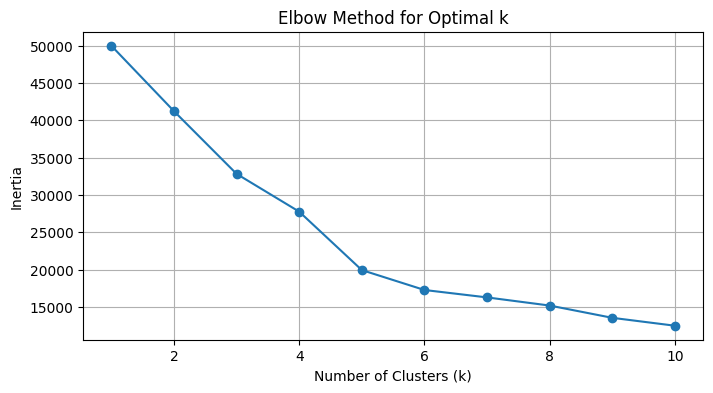

In [34]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [35]:
kmeans = KMeans(n_clusters=3, random_state=42)
numeric_cols['Cluster'] = kmeans.fit_predict(scaled_features)


In [37]:
df['Cluster'] = numeric_cols['Cluster']


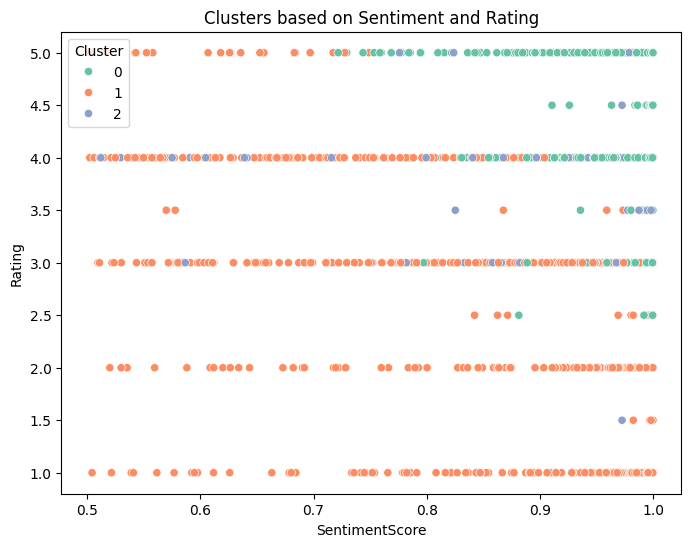

In [38]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='SentimentScore', y='Rating', hue='Cluster', palette='Set2')
plt.title('Clusters based on Sentiment and Rating')
plt.show()

In [41]:
sil_score = silhouette_score(scaled_features, kmeans.labels_)
sil_score

0.33421458202200366

In [46]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [45]:
calinski_score = calinski_harabasz_score(scaled_features, kmeans.labels_)
calinski_score

2615.4515259378572

In [47]:
db_score = davies_bouldin_score(scaled_features, kmeans.labels_)
db_score

1.2886155560822534

This project successfully demonstrates how modern NLP techniques, combined with robust machine learning workflows, can unlock valuable insights from customer reviews. By analyzing sentiments and clustering customer feedback, we identified patterns in how different groups perceive service quality and cuisine types. The results can guide restaurants in refining their offerings, targeting specific customer groups, and improving overall service strategies. Furthermore, the ability to automate sentiment detection and segment customers using unsupervised learning makes this solution scalable and adaptable for real-time feedback monitoring in any customer-centric business domai